In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objects import *
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA


In [2]:
from matplotlib import font_manager, rc
font_path='C:\Windows\Fonts/malgun.ttf'
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)

In [3]:
city = pd.read_csv('기상데이터/개정 날씨데이터/강동구_포트홀_날씨.csv')
city['Date'] = pd.to_datetime(city.Date)
city.index = city['Date']
city.drop('Date', axis=1, inplace=True)

In [4]:
city.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1247 entries, 2019-01-01 to 2022-05-31
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   강수량     1247 non-null   float64
 1   강설량     1247 non-null   float64
 2   최고기온    1247 non-null   float64
 3   최저기온    1247 non-null   float64
 4   습도      1247 non-null   float64
 5   강수형태    1247 non-null   float64
 6   강수확률    1247 non-null   float64
 7   발생건수    1247 non-null   float64
 8   파손면적합계  1247 non-null   float64
 9   일교차     1247 non-null   float64
dtypes: float64(10)
memory usage: 107.2 KB


### 예측
- target : 발생건수

In [5]:
X = city.drop(['발생건수'],axis=1)
y = city['발생건수']

In [6]:
X_train = X.loc[:"2021-06-30"]
y_train = y.loc[:"2021-06-30"]
X_test = X.loc["2021-07-01":]
y_test = y.loc["2021-07-01":]

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((912, 9), (912,), (335, 9), (335,))

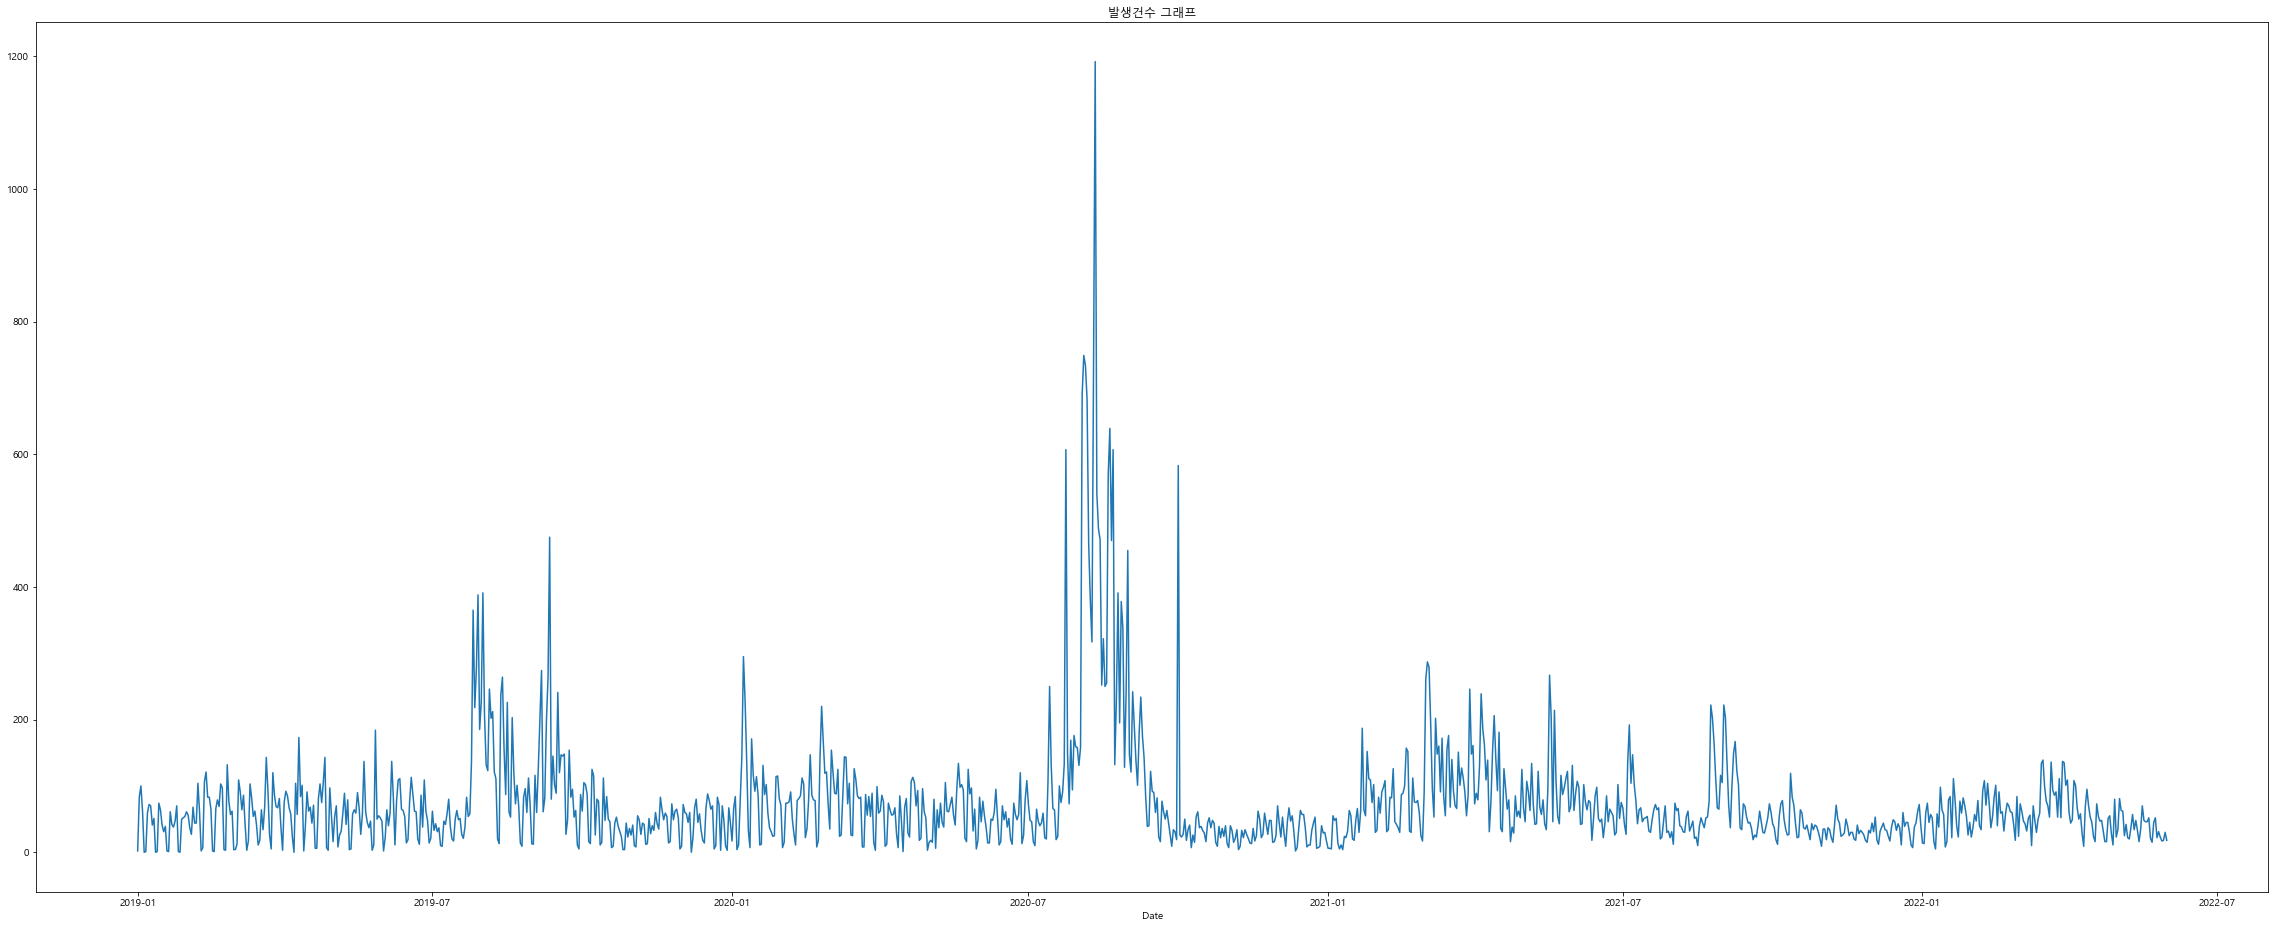

In [8]:
plt.figure(figsize=(40,16))
plt.plot(city.index, city.발생건수)
plt.title("발생건수 그래프")
plt.xlabel("Date")
plt.show()

In [9]:
ts = city[['발생건수']]
ts

,발생건수
Date,
2019-01-01,2.0
2019-01-02,83.0
2019-01-03,100.0
2019-01-04,62.0
2019-01-05,0.0
...,...
2022-05-27,23.0
2022-05-28,17.0
2022-05-29,18.0


<Figure size 2160x1152 with 0 Axes>

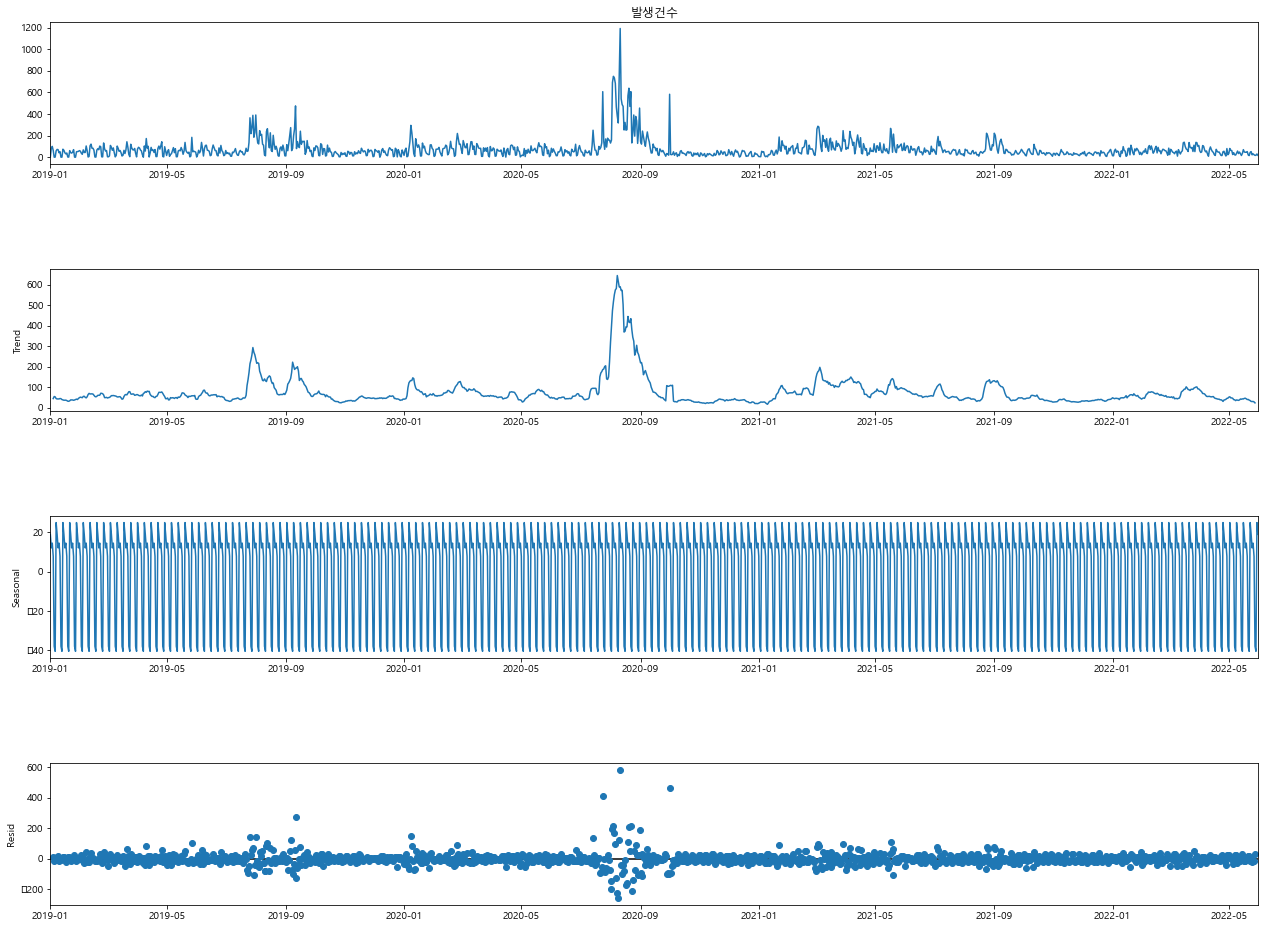

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['발생건수'], model='additive')

fig = plt.figure(figsize=(30,16))
fig = result.plot()
fig.set_size_inches(20,15)

In [11]:
city.reset_index(inplace=True)

In [12]:
df = city.copy()
df.head()

,Date,강수량,강설량,최고기온,최저기온,습도,강수형태,강수확률,발생건수,파손면적합계,일교차
0,2019-01-01,0.0,0.0,1.0,-6.0,40.0,0.0,0.0,2.0,0.18,7.0
1,2019-01-02,0.0,0.0,2.0,-5.0,30.0,0.0,0.0,83.0,19.61,7.0
2,2019-01-03,0.0,0.0,5.0,-5.0,30.0,0.0,0.0,100.0,22.03,10.0
3,2019-01-04,0.0,0.0,2.0,-6.0,60.0,0.0,20.0,62.0,21.46,8.0
4,2019-01-05,0.0,0.0,2.0,-6.0,25.0,0.0,10.0,0.0,0.00,8.0


In [13]:
df = df.set_index("Date").resample('m').발생건수.mean().reset_index()
df.head()

,Date,발생건수
0,2019-01-31,40.967742
1,2019-02-28,59.285714
2,2019-03-31,54.774194
3,2019-04-30,65.966667
4,2019-05-31,52.741935


In [14]:
# check stationarity (정지 상태 확인 -> 정상성 확인)
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(ts['발생건수'])
def adfuller_test(target):
    result = adfuller(target, autolag = None, maxlag = 1)
    # sales : 검증할 데이터 계열, autolag : 0,1,...maxlag값 중 lag길이를 자동으로 결정시 사용
    # maxlag : 최대 지연-> 테스트에 포함된 최대 지연
    labels = ['ADF  Test Statistic', 'p-value', '#Lags Used', \
             'Number of Observations']
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), \
            reject the null hypothesis. Data is stationary")
        else:
            print("weak evidence against null hypothesis,indicating \
            it is non-stationary ")
            
adfuller_test(df['발생건수'])

ADF  Test Statistic : -4.3422609464213755
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary
p-value : 0.00037502927821803317
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary
#Lags Used : 1
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary
Number of Observations : 39
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary


In [15]:
# 이전과의 차이를 구하는 칼럼을 만들어 이전 값과의 차이를 구함
df['발생건수차이'] = df['발생건수'] - df['발생건수'].shift(1)
df.set_index('Date',inplace=True)
df.head()

,발생건수,발생건수차이
Date,,
2019-01-31,40.967742,NaN
2019-02-28,59.285714,18.317972
2019-03-31,54.774194,-4.511521
2019-04-30,65.966667,11.192473
2019-05-31,52.741935,-13.224731


In [16]:
adfuller_test(df['발생건수차이'].dropna())

ADF  Test Statistic : -6.179755126329891
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary
p-value : 6.498299411472671e-08
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary
#Lags Used : 1
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary
Number of Observations : 38
strong evidence against the null hypothesis(Ho),             reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='Date'>

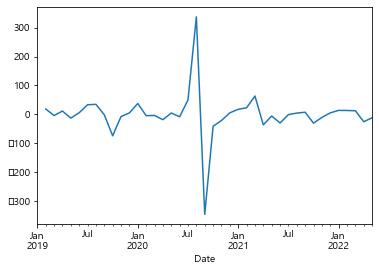

In [17]:
df['발생건수차이'].plot()

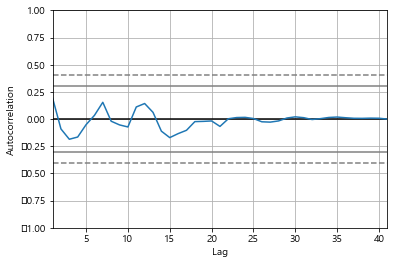

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['발생건수'])
plt.show()

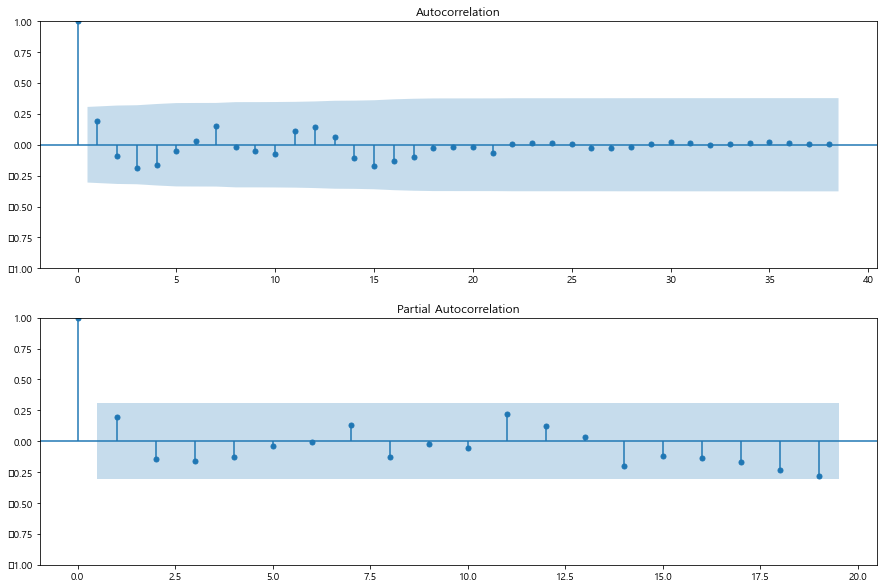

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
# lag : 데이터 상 과거의 몇번째 뒤로 간 데이터, lag이 1이라면, 한달 전 데이터와 현재 데이터 비교
# x축은 lag의 개수, y축 : lag의 개수에 따른 데이터와 상관관계 출력
fig = sm.graphics.tsa.plot_acf(df['발생건수'].dropna(), lags=38, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['발생건수'].dropna(), lags=19, ax=ax2)
#샘플 크기의 최대 50%까지 지연에 대한 편상관만 계산할 수 있습니다. 요청된 nlag는 27 미만이어야 합니다.

In [20]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
ARIMA_model = ARIMA(df['발생건수'], order = (1,1,1)) #(p,d,q)
results_arima = ARIMA_model.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   발생건수   No. Observations:                   41
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -223.784
Date:                Fri, 04 Nov 2022   AIC                            453.568
Time:                        20:40:19   BIC                            458.634
Sample:                    01-31-2019   HQIC                           455.400
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2218      0.222      0.997      0.319      -0.214       0.658
ma.L1         -0.9988     11.199     -0.089      0.929     -22.948      20.950
sigma2      3907.4714   4.31e+04      0.091      0.9

In [21]:
#ARMA
from statsmodels.tsa.arima.model import ARIMA
ARMA_model = ARIMA(df['발생건수'], order=(1, 0, 1)) # d가 0이면 ARMA이다.
results_arma = ARMA_model.fit()
print(results_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                   발생건수   No. Observations:                   41
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -227.043
Date:                Fri, 04 Nov 2022   AIC                            462.087
Time:                        20:40:19   BIC                            468.941
Sample:                    01-31-2019   HQIC                           464.583
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.2419     32.322      2.297      0.022      10.891     137.592
ar.L1         -0.0827      1.838     -0.045      0.964      -3.685       3.520
ma.L1          0.2970      1.888      0.157      0.8

In [22]:
#MA
from statsmodels.tsa.arima.model import ARIMA
MA_model = ARIMA(df['발생건수'], order=(0, 0, 1)) # P, D가 0이면 MA
results_ma = MA_model.fit()
print(results_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                   발생건수   No. Observations:                   41
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -227.055
Date:                Fri, 04 Nov 2022   AIC                            460.109
Time:                        20:40:19   BIC                            465.250
Sample:                    01-31-2019   HQIC                           461.981
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.4147     32.149      2.315      0.021      11.403     137.426
ma.L1          0.2204      0.186      1.183      0.237      -0.145       0.585
sigma2      3776.8836    579.350      6.519      0.0

In [23]:
#AR
from statsmodels.tsa.arima.model import ARIMA
AR_model = ARIMA(df['발생건수'], order=(5, 0, 0)) # d, q가 0이면 AR
results_ar = AR_model.fit()
print(results_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                   발생건수   No. Observations:                   41
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -226.120
Date:                Fri, 04 Nov 2022   AIC                            466.240
Time:                        20:40:20   BIC                            478.235
Sample:                    01-31-2019   HQIC                           470.608
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.1159     28.566      2.630      0.009      19.128     131.104
ar.L1          0.1734      0.225      0.772      0.440      -0.267       0.614
ar.L2         -0.1150      0.694     -0.166      0.8

<AxesSubplot:xlabel='Date'>

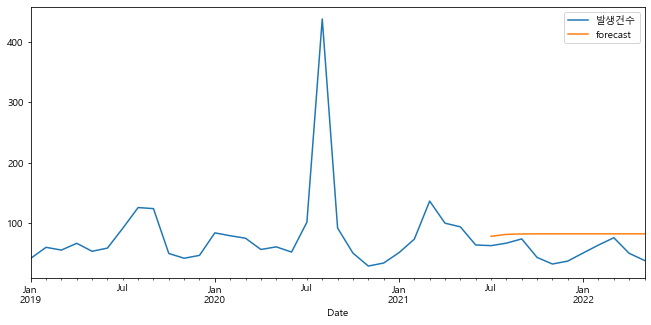

In [24]:
# ARIMA를 통한 예측 (현재의 결과 예측)
df['forecast']=results_arima.predict(start = '2021-07-31', end = '2022-05-31',dynamic=True)
df[['발생건수','forecast']].plot(figsize=(11, 5))

In [25]:
df

,발생건수,발생건수차이,forecast
Date,,,
2019-01-31,40.967742,NaN,NaN
2019-02-28,59.285714,18.317972,NaN
2019-03-31,54.774194,-4.511521,NaN
2019-04-30,65.966667,11.192473,NaN
2019-05-31,52.741935,-13.224731,NaN
2019-06-30,58.033333,5.291398,NaN
2019-07-31,90.903226,32.869892,NaN
2019-08-31,125.322581,34.419355,NaN
2019-09-30,123.566667,-1.755914,NaN


In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(df['발생건수'], order=(2,1,1), \
                      seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

LinAlgError: LU decomposition error.

## LSTM

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2019-01-31 to 2022-05-31
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   발생건수      41 non-null     float64
 1   발생건수차이    40 non-null     float64
 2   forecast  11 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB


In [27]:
city.shape

(1247, 11)

In [28]:
city

,Date,강수량,강설량,최고기온,최저기온,습도,강수형태,강수확률,발생건수,파손면적합계,일교차
0,2019-01-01,0.0,0.0,1.0,-6.0,40.0,0.0,0.0,2.0,0.18,7.0
1,2019-01-02,0.0,0.0,2.0,-5.0,30.0,0.0,0.0,83.0,19.61,7.0
2,2019-01-03,0.0,0.0,5.0,-5.0,30.0,0.0,0.0,100.0,22.03,10.0
3,2019-01-04,0.0,0.0,2.0,-6.0,60.0,0.0,20.0,62.0,21.46,8.0
4,2019-01-05,0.0,0.0,2.0,-6.0,25.0,0.0,10.0,0.0,0.00,8.0
...,...,...,...,...,...,...,...,...,...,...,...
1242,2022-05-27,0.0,0.0,29.0,15.0,45.0,0.0,0.0,23.0,19.44,14.0
1243,2022-05-28,0.0,0.0,29.0,16.5,45.0,0.0,0.0,17.0,4.32,12.5
1244,2022-05-29,0.0,0.0,24.0,16.5,45.0,0.0,0.0,18.0,6.95,7.5
1245,2022-05-30,0.0,0.0,26.0,16.0,70.0,0.0,30.0,30.0,47.49,10.0


In [29]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 1246
n_feature=11
generator = TimeseriesGenerator(city, city,\
                               length=n_input, batch_size=1)

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import  LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape = (n_input, n_feature)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               169600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 169,801
Trainable params: 169,801
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm_model.fit_generator(generator, epochs=5)

KeyError: 1246